In [1]:
import cv2
import h5py
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd

In [2]:
def time_from_start(end_time):
    t_step = end_time.replace(tzinfo=None)  - moves_df.start_time[0].replace(tzinfo=None) 
    frame_number = t_step.total_seconds()
    return frame_number

In [3]:
# Load Video and stats
cap = cv2.VideoCapture('./data/overhang/Overhang.mp4')
ret, frame = cap.read()
cv2.imshow('frame', frame)
fps = cap.get(cv2.cv2.CAP_PROP_FPS)
width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [4]:
# Load and preprocess moves data corresponding to video
moves_df = pd.read_csv("./data/overhang/bae8f52c-407e-5f89-a8e3-61fcca51ee0a_moves.csv")
moves_df[['start_time', 'end_time']] = moves_df[['start_time', 'end_time']].apply(pd.to_datetime)
moves_df['time_from_start'] = moves_df['end_time'].apply(time_from_start)

In [5]:
# Load and preprocess moves data corresponding to video
h5_file_name = './data/overhang/bae8f52c-407e-5f89-a8e3-61fcca51ee0a.h5'
f = h5py.File(h5_file_name, 'r')
height_profile = f['climbs/0/height_profile']

In [6]:
# playback speed = out_fps/30 * speed_up   
# speed_up is positive int, e.g. 2 means skip every 2nd frame, 3 skip every 3rd frame
# start_time is the time to start plotting
def overlayGraph(infile, outfile, graphFunc, start_time, end_time, out_fps, speed_up):
    cap = cv2.VideoCapture(infile)
    writer = cv2.VideoWriter(outfile, cv2.VideoWriter_fourcc(*'MP4V'), out_fps, (width, height))    

    """ Set figure size, so it's not bigger than video """
    figure(num=None, figsize=(width/80, height/80), dpi=80)
    frame_count = 0 # count which frame we are on

    while True:
        if not (frame_count % speed_up == 0):
            cap.read()
            frame_count += 1
            continue
        ret, frame = cap.read()
        # original video has 30fps, so divide frames by 30 to get current time
        time = frame_count / fps;

        if not ret:
            break

        # we edit frame to overlay a graph. graphFunc could be replaced by
        # another function to modify frames
        if start_time < time and time < end_time:
            data_time = time - start_time
            frame = graphFunc(data_time, frame)        
            query_df = moves_df[moves_df['time_from_start'] <= data_time]
            if query_df.shape[0] != 0:
                cv2.putText(frame, "Total Moves {}".format(query_df.move_index.max()),
                                                           (10, 50), cv2.FONT_HERSHEY_SIMPLEX,
                                                           0.5, (255, 255, 255), 1)

        writer.write(frame)
        cv2.imshow('frame', frame)

        if cv2.waitKey(1) & 0xFF == 27:
            break
            
        frame_count += 1

    cap.release()
    writer.release()
    cv2.destroyAllWindows()

max_height = max(height_profile)
len_height = len(height_profile)
def graphFunc(time, frame):
    if time > len_height / 10:
        return frame
    plt.clf()
    # for '/climbs/0/height_profile' we are sampling at 10Hz, i.e. every 0.1s
    ind = min(math.floor(time/0.1), len_height) # stay in bounds
    plt.plot(height_profile[:math.floor(time/0.1)], linewidth=7.0, alpha=0.5)
    plt.ylim(0,max_height)
    plt.xlim(0,len_height)
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.axes.xaxis.set_visible(False)
    
    plt.savefig('plot.png', transparent=True)

    # imread_unchange reads plot.png with 4 channels, i.e. including alpha channel which
    # describes the transparancy
    overlay = cv2.imread('plot.png', cv2.IMREAD_UNCHANGED)
    new_frame = frame

    y_offset = x_offset = 5
    y1, y2 = y_offset, y_offset + overlay.shape[0]
    x1, x2 = x_offset, x_offset + overlay.shape[1]
    alpha_o = overlay[:, :, 3] / 255.0
    alpha_n = 1.0 - alpha_o

    for c in range(0, 3):
        new_frame[y1:y2, x1:x2, c] = (alpha_o * overlay[:, :, c] +
                                  alpha_n * new_frame[y1:y2, x1:x2, c])
    
    return new_frame

In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data
h5_file_name = './data/overhang/bae8f52c-407e-5f89-a8e3-61fcca51ee0a.h5'
f = h5py.File(h5_file_name, 'r')
height_profile = f['climbs/0/height_profile']
max_height = max(height_profile)
len_height = len(height_profile)
rocket = Image.open('../rocket.png')
rocket = rocket.resize((50,50))

def imscatter(x, y, image, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

def rocketGraphFunc(time, frame):
    if time > len_height / 10:
        return frame
    plt.clf()
    # for '/climbs/0/height_profile' we are sampling at 10Hz, i.e. every 0.1s
    ind = min(math.floor(time/0.1), len_height - 1) # stay in bounds

    nr_readings = math.floor(time/0.1)
    if nr_readings == 0:
        return frame
    
    x = range(nr_readings)
    y = height_profile[:nr_readings]
    plt.plot(x, y, linewidth=7.0, alpha=0.5)

    ax = plt.gca()
    imscatter([nr_readings], [height_profile[nr_readings - 1]],
              '../rocket.png', zoom=0.1, ax=ax)
    plt.ylim(0,max_height)
    plt.xlim(0,len_height)

    ax.annotate(xy=(x[-1], y[-1]), xytext=(25,0), textcoords='offset points',
                text=str("{:.1f}".format(y[-1])), va='center')
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    fig_width = frame.shape[0]
    fig_height = frame.shape[1]

    plt.savefig('plot.png', transparent=True)

    # imread_unchange reads plot.png with 4 channels, i.e. including alpha channel which
    # describes the transparancy
    overlay = cv2.imread('plot.png', cv2.IMREAD_UNCHANGED)
    new_frame = frame

    y_offset = x_offset = 0
    y1, y2 = y_offset, y_offset + overlay.shape[0]
    x1, x2 = x_offset, x_offset + overlay.shape[1]
    alpha_o = overlay[:, :, 3] / 255.0
    alpha_n = 1.0 - alpha_o

    for c in range(0, 3):
        new_frame[y1:y2, x1:x2, c] = (alpha_o * overlay[:, :, c] +
                                  alpha_n * new_frame[y1:y2, x1:x2, c])

    return new_frame

0.0016253968253980844
0.3350264550264548
0.6684275132275133
1.0018285714285717
1.3352296296296302
1.6686306878306887
2.002031746031747
2.3354328042328056
2.6688338624338623
3.002234920634921
3.3356359788359793
3.6690370370370378
4.002438095238096
4.335839153439155
4.669240211640213
5.00264126984127
5.336042328042328
5.669443386243387
6.002844444444445
6.336245502645504
6.669646560846562
7.003047619047621
7.336448677248677
7.669849735449736
8.003250793650796
8.336651851851851
8.67005291005291
9.003453968253968
9.336855026455027
9.670256084656085
10.003657142857143
10.337058201058202
10.67045925925926
11.003860317460319
11.337261375661377
11.670662433862436
12.004063492063494
12.337464550264553
12.670865608465611
13.004266666666666
13.337667724867725
13.671068783068783
14.004469841269842
14.3378708994709
14.671271957671959
15.004673015873017
15.338074074074076
15.671475132275134
16.004876190476192
16.33827724867725
16.67167830687831
17.005079365079368
17.338480423280426
17.67188148148148

149.0318984126984
149.3652994708995
149.69870052910053
150.0321015873016
150.36550264550266
150.6989037037037
151.03230476190478
151.36570582010583
151.69910687830688
152.03250793650795
152.365908994709
152.69931005291005
153.03271111111113
153.36611216931217
153.69951322751325
154.0329142857143
154.36631534391535
154.69971640211642
155.03311746031747
155.36651851851852
155.6999195767196
156.03332063492064
156.3667216931217
156.70012275132277
157.0335238095238
157.3669248677249
157.70032592592594
158.033726984127
158.36712804232806
158.7005291005291
159.03393015873016
159.36733121693123
159.70073227513228
160.03413333333333
160.3675343915344
160.70093544973545
161.03433650793653
161.36773756613758
161.70113862433863
162.0345396825397
162.36794074074075
162.7013417989418
163.03474285714287
163.36814391534392
163.701544973545
164.03494603174605
164.3683470899471
164.70174814814817
165.03514920634922
165.36855026455027
165.70195132275134
166.0353523809524
166.36875343915344
166.7021544973

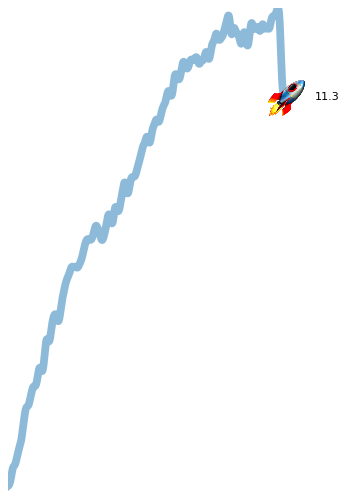

In [8]:
overlayGraph('./data/overhang/Overhang.mp4', 'graphvid.mp4', rocketGraphFunc, 8, 10000, 60, 10)